In [388]:
import os
import cv2
import keras
from pickle import load,dump
from skimage import exposure
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing import image
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,Dense
import matplotlib.pyplot as plt
from PIL import Image,ImageFilter
import numpy as np
%matplotlib inline  
#for inline graphical plotting

In [389]:
#path_to_training = "../../Dataset/UJTDchar/Train/"
#path_to_validation = "../../Dataset/UJTDchar/Validation/"
#files_training = os.listdir(path_to_training)
#files_validation = os.listdir(path_to_validation)
path_train_img = "../../Dataset/UJTDchar/Train/shuffled_img.txt"
path_train_labels = "../../Dataset/UJTDchar/Train/shuffled_labels.txt"
path_val_img = "../../Dataset/UJTDchar/Validation/shuffled_images.txt"
path_val_labels = "../../Dataset/UJTDchar/Validation/shuffled_labels.txt"
#character_list = os.listdir(path_to_training)
char_to_index = {}
index_to_char = {}
char_big_img = {}
char_small_img = {}
char_ab_threshold = []
no_of_images = 0 
num_classes = 124
#print(len(character_list))
#print(files)
for i in character_list:
    char_small_img[i] = 0  ##no of small images for each character
    char_big_img[i] = 0    ##no of large images for each character
#print(char_big_img)
x = []
threshold = 40
small_images = 0
avg_height = 0 
avg_width = 0 
valid_images = [".jpg",".gif",".png",".tga"]
dim = (32,32)

In [390]:
def apply_filters_to_images(path,files):
    for file in files:
        path1 = os.path.join(path,file)
        images = os.listdir(path1)
        for j,image in enumerate(images):
            path2 = os.path.join(path1,image)
            img = Image.open(path2,mode='r')
            blur=img.filter(ImageFilter.BLUR)
            ee=img.filter(ImageFilter.EDGE_ENHANCE)
            contour=img.filter(ImageFilter.CONTOUR)
            detail=img.filter(ImageFilter.DETAIL)
            emboss=img.filter(ImageFilter.EMBOSS)
            smooth=img.filter(ImageFilter.SMOOTH)
            sharpen=img.filter(ImageFilter.SHARPEN)
            smooth_more=img.filter(ImageFilter.SMOOTH_MORE)
            ee.save(os.path.join(path1,"EEz"+str(j)+".jpg"))
            blur.save(os.path.join(path1,"blsdur"+str(j)+".jpg"))
            contour.save(os.path.join(path1,"cadsontour"+str(j)+".jpg"))
            detail.save(os.path.join(path1,"deasftail"+str(j)+".jpg"))
            emboss.save(os.path.join(path1,"emasdasboss"+str(j)+".jpg"))
            smooth.save(os.path.join(path1,"smasdaooth"+str(j)+".jpg"))
            sharpen.save(os.path.join(path1,"shsadarpen"+str(j)+".jpg"))
            smooth_more.save(os.path.join(path1,"smooasdth_more_"+str(j)+".jpg"))

In [391]:
def loading_all_images(valid_images,x,path,threshold,char_small_img,char_big_img,char_ab_threshold,files,character_list,dim,avg_height,avg_width,small_images):
    for i,file in enumerate(files):
        path1 = os.path.join(path,file)
        images = os.listdir(path1)
        for image in images:
            ext = os.path.splitext(image)
            if ext[1].lower() in valid_images:
                img = cv2.imread(os.path.join(path1,image),0)
                #img_eq = exposure.equalize_hist(img)
                avg_height = avg_height + img.shape[1]
                avg_width = avg_width + img.shape[0]
                if img.shape < dim:
                    small_images+=1
                    split = os.path.split(os.path.join(path1,image))
                    split1 = os.path.split(split[0])
                    if split1[1] in character_list:
                        char_small_img[split1[1]]+=1
                    img_resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
                else:
                    split = os.path.split(os.path.join(path1,image))
                    split1 = os.path.split(split[0])
                    if split1[1] in character_list:
                        char_big_img[split1[1]]+=1
                    img_resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
                x.append(img_resize)
    return x

In [392]:
#x = loading_all_images(valid_images,x,path,threshold,char_small_img,char_big_img,char_ab_threshold,files,character_list,dim,avg_height,avg_width,small_images)

In [393]:
def loadBatchImages(path,files):
    x = []
    for file in files:
        path1 = os.path.join(path,file)
        images = os.listdir(path1)
        for image in images:
            ext = os.path.splitext(image)
            if ext[1].lower() in valid_images:
                img = cv2.imread(os.path.join(path1,image),0)
                #img_eq = exposure.equalize_hist(img)
                img_resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
                x.append(img_resize)
    np.asarray(x)
    x = np.expand_dims(x,axis=-1)
    return x 

In [394]:
def loadImagePaths(path):
    img_paths = []
    with open(path,"r") as file:
        for f in file:
            img_paths.append(f.split("\n")[0]) ##read from shuffled image file and store in a list
    return img_paths

In [395]:
def loadLabelPaths(path):
    labels = []
    with open(path,"r") as file:
        for f in file:
            labels.append(f.split("\n")[0]) ##read from shuffled label file and store in list
    return labels

In [396]:
def loadImageFromList(img_list,batch_start,limit):
    x = []
    for i in range(batch_start,limit):
        img = cv2.imread(img_list[i],0)    ##read image paths from the image path list
        img_resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        x.append(img_resize)
    np.asarray(x)
    x = np.expand_dims(x,axis=-1)
    return x                         ##return image read as numpy array

In [397]:
def loadLabelFromList(num_classes,labels,batch_start,limit):
    label_list = []
    label_list = [labels[i] for i in range(batch_start,limit)] ##read labels from label list
    y_train = np.asarray(label_list)  ##make label list as numpy array
    y_train = keras.utils.to_categorical(y_train, num_classes)  ##make data categorical format
    return y_train

In [398]:
##def loadBatchTargets(num_classes,batch_start,limit,number):
    ##label_list = []
    ##for j in range(batch_start,limit):
        ##temp = [j for i in range(0,number)]
        ##label_list = label_list + temp 
    #print(label_list)    
    ##y_train = np.asarray(label_list)
    ##y_train = keras.utils.to_categorical(y_train, num_classes)
    #print(y_train.shape)
    ##return y_train

In [418]:
def batchTrainingImageLoader(path_img,path_labels,batch_size,num_classes):

    
    img_paths = loadImagePaths(path_img)
    labels = loadLabelPaths(path_labels)
    L = len(img_paths)
    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            #x_train = loadBatchImages(path,files[batch_start:limit])
            x_train = loadImageFromList(img_paths,batch_start,limit)
            #y_train = loadBatchTargets(num_classes,batch_start,limit,number=720)
            y_train = loadLabelFromList(num_classes,labels,batch_start,limit)
            datagen_train = data_augment_train(x_train,y_train)
            datagen_train.fit(x_train)
            for X_batch, y_batch in datagen_train.flow(x_train,y_train,batch_size=16,shuffle=True):
                yield (X_batch,y_batch) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [442]:
def batchValidationImageLoader(path_img,path_labels,batch_size,num_classes):
    
    
    img_paths = loadImagePaths(path_img)
    labels = loadLabelPaths(path_labels)
    L = len(img_paths)
    
    while True:
        
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            #x_val = loadBatchImages(path,files[batch_start:limit])
            x_val = loadImageFromList(img_paths,batch_start,limit)
            #y_val = loadBatchTargets(num_classes,batch_start,limit,number=180)
            y_val = loadLabelFromList(num_classes,labels,batch_start,limit)
            datagen_val = data_augment_val(x_val,y_val)
            datagen_val.fit(x_val)
            for X_batch, y_batch in datagen_val.flow(x_val,y_val,batch_size=16,shuffle=True):
                yield (X_batch,y_batch) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [443]:
#batchTrainingImageLoader(path,files,batch_size=10,num_classes=124)

In [444]:
#batchValidationImageLoader(path,files,batch_size=10,num_classes=124)

In [445]:
avg_height = (avg_height//12400)
avg_width = (avg_width//12400)
for key,val in char_big_img.items():
    if val > threshold:
        char_ab_threshold.append(key)
        #print(val)
#print(char_ab_threshold)

In [446]:
def load_img_for_11_classes():
    for i,file in enumerate(files):
        path1 = os.path.join(path,file)
        images = os.listdir(path1)
        for image in images:
            ext = os.path.splitext(image)
            if ext[1].lower() in valid_images:
                img = cv2.imread(os.path.join(path1,image),0)
                img_eq = exposure.equalize_hist(img)
                #blur = cv2.GaussianBlur(img,(5,5),0)
                if img.shape >= dim:
                    split = os.path.split(os.path.join(path1,image))
                    #print(split)
                    split1 = os.path.split(split[0])
                    #print(split1)
                    if split1[1] in char_ab_threshold:
                        img_resize = cv2.resize(img_eq, dim, interpolation = cv2.INTER_AREA)
                        x.append(img_resize)
                        #filenames.append(os.path.join(path1,image))

In [447]:
#x_train = np.array(x)
#x_train = np.expand_dims(x,axis=-1)
#print(x_train.shape)

In [448]:
#plt.imshow(img_resize) ##sample image visualizing 

In [449]:
#label_to_char_mapping = {0 : 'A' , 1 : 'Aa' , 2 : 'I'}
#print(label_to_char_mapping)
def create_labels_for_11_classes():
    label_list = []
    temp = []
    """for j in range(0,len(char_ab_threshold)):    
        temp = [j for i in range(0,char_big_img[key]) if key in char_ab_threshold]
        label_list = label_list + temp
    """
    label_list = [0 for i in range(1,43)] + [1 for i in range(1,44)]+ [2 for i in range(1,43)] + [3 for i in range(1,46)] + [4 for i in range(1,43)] + [5 for i in range(1,42)] + [6 for i in range(1,46)] + [7 for i in range(1,43)]+ [8 for i in range(1,42)] + [9 for i in range(1,43)] + [10 for i in range(1,44)]
    print(label_list) 
    y_train = np.asarray(label_list)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    print(y_train.shape)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42,stratified=y)
    print(x_train.shape)
    print(x_val.shape)
    print(y_train.shape)
    print(y_val.shape)

In [450]:
def prepare_labels_for_all_images(num_classes):
    #label_to_char_mapping = {0 : 'A' , 1 : 'Aa' , 2 : 'I'}
    #print(label_to_char_mapping)
    label_list = []
    for j in range(0,num_classes):
        temp = [j for i in range(1,101)]
        label_list = label_list + temp 
    print(label_list)    
    y_train = np.asarray(label_list)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    print(y_train.shape)
    #x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
    return y_train

In [451]:
def split_train_val(x_train,y_train):
    x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.10,random_state=42,stratify=y_train)
    return x_train,x_val,y_train,y_val

In [452]:
def data_augment_train(x_train,y_train):
    x_train = x_train.astype('float32')
    datagen_train = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
    #os.makedirs('aug_images')
    datagen_train.fit(x_train)
    for X_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=9):
        # create a grid of 3x3 images
        for i in range(0, 9):
            plt.subplot(330 + 1 + i)
            plt.imshow(X_batch[i].reshape(32,32),cmap=plt.get_cmap('gray'))
        # show the plot
        plt.show()
        break
    return datagen_train

In [453]:
def data_augment_val(x_val,y_val):
    x_val = x_val.astype('float32')
    datagen_val = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
    datagen_val.fit(x_val)
    for X_batch,y_batch in datagen_val.flow(x_val,y_val,batch_size=9):
        for i in range(0,9):
            plt.subplot(330 + 1 + i)
            plt.imshow(X_batch[i].reshape(32,32),cmap=plt.get_cmap('gray'))
        plt.show()
        break
    return datagen_val

In [454]:
#label_list = [0 for i in range(1,101)] + [1 for i in range(1,101)]+ [2 for i in range(1,101)]
#label_to_char_mapping = {0 : 'A' , 1 : 'Aa' , 2 : 'I'}
#print(label_to_char_mapping)
#y_train = prepare_labels(num_classes)
#x_train,x_val,y_train,y_val = split_train_val(x_train,y_train)

In [455]:
#datagen_train = data_augment_train(x_train,y_train)
#datagen_val = data_augment_val(x_val,y_val)

In [456]:
#train_generator = datagen_train.flow_from_directory(path,target_size=(32,32),batch_size=32,save_to_dir="aug_images1",save_format='jpg')
directory_list = os.listdir("../../Dataset/UJTDchar/Train")
directory_list = [f for f in directory_list if not f.endswith(".txt")]
#print(directory_list)
for i,char in enumerate(directory_list):
    char_to_index[char] = i  
print(char_to_index)
for key,val in char_to_index.items():
    index_to_char[val] = key
#datagen_train.fit
#print(index_to_char)

{'ஞ': 0, 'ெ': 1, 'சீ': 2, 'றீ': 3, 'ங': 4, 'ள்': 5, 'ை': 6, 'டு': 7, 'தூ': 8, 'ண்': 9, 'U': 10, 'ல': 11, 'ே': 12, 'று': 13, 'யீ': 14, 'லூ': 15, 'லு': 16, 'ரீ': 17, 'னீ': 18, 'நூ': 19, 'ஙி': 20, 'ற': 21, 'ட்': 22, 'பு': 23, 'கீ': 24, 'டீ': 25, 'றி': 26, 'ஞீ': 27, 'ஙீ': 28, 'லீ': 29, 'ட': 30, 'மூ': 31, 'னி': 32, 'னு': 33, 'ஞி': 34, 'ழூ': 35, 'தி': 36, 'யூ': 37, 'I': 38, 'பீ': 39, 'ணீ': 40, 'ற்': 41, 'ணூ': 42, 'டூ': 43, 'ல்': 44, 'லி': 45, 'சூ': 46, 'கு': 47, 'ர': 48, 'ணு': 49, 'க': 50, 'ந்': 51, 'க்': 52, 'Aa': 53, 'றூ': 54, 'ம': 55, 'ம்': 56, 'ஞூ': 57, 'மி': 58, 'வ': 59, 'பூ': 60, 'வி': 61, 'சி': 62, 'ஒ': 63, 'ளூ': 64, 'நி': 65, 'கி': 66, 'எ': 67, 'ன': 68, 'ஏ': 69, 'மீ': 70, 'ழி': 71, 'தீ': 72, 'ஙு': 73, 'ரி': 74, 'வீ': 75, 'ரு': 76, 'ர்': 77, 'நீ': 78, 'ழ்': 79, 'ழ': 80, 'ளி': 81, 'கூ': 82, 'ன்': 83, 'நு': 84, 'ங்': 85, 'ளு': 86, 'மு': 87, 'வூ': 88, 'ப': 89, 'ரூ': 90, 'யு': 91, 'ந': 92, 'ஐ': 93, 'ச்': 94, 'த': 95, 'ஓ': 96, 'ய்': 97, 'ஙூ': 98, 'ா': 99, 'ணி': 100, 'ய': 101, 'ழீ': 102, 'த

In [457]:
def cnn_model(path_train_img,path_train_labels,path_val_img,path_val_labels,load_size,num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(32,32,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64,(3 , 3) , activation = 'relu'))
    model.add(Conv2D(64,(3 , 3) , activation = 'relu'))
    model.add(Conv2D(64,(3 , 3) , activation = 'relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(124,activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    checkpointer = ModelCheckpoint(filepath='model_filters4.hdf5',monitor='val_loss',verbose=1, save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss',patience=10)
    history = model.fit_generator(generator=batchTrainingImageLoader(path_train_img,path_train_labels,5000,num_classes),
                        steps_per_epoch=89280//16,validation_data=batchValidationImageLoader(path_val_img,path_val_labels,5000,num_classes),
                        validation_steps=22320//16,epochs=20,callbacks=[checkpointer,earlystopping])
    #model.save('model_filters.hdf5')
    with open('trainHistoryfilters4.pkl', 'wb') as fp:
        dump(history.history, fp)
    return model
    #model.fit(x_train, y_train,batch_size=32,epochs=100,verbose=1,validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 8, 8, 64)          36928     
__________

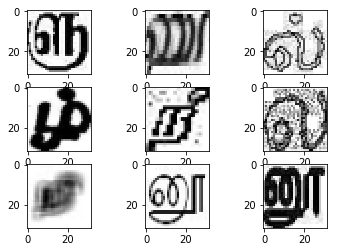

5579/5580 [============================>.] - ETA: 0s - loss: 0.6957 - acc: 0.8143

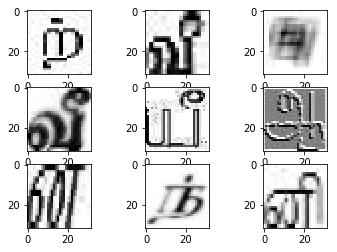

Epoch 00001: val_loss improved from inf to 1.05032, saving model to model_filters4.hdf5
5580/5580 [==============================] - 803s 144ms/step - loss: 0.6956 - acc: 0.8143 - val_loss: 1.0503 - val_acc: 0.8062
Epoch 2/20
5580/5580 [==============================] - 710s 127ms/step - loss: 0.0954 - acc: 0.9700 - val_loss: 1.1592 - val_acc: 0.8060
Epoch 3/20
5580/5580 [==============================] - 683s 122ms/step - loss: 0.0647 - acc: 0.9806 - val_loss: 1.2395 - val_acc: 0.8179
Epoch 4/20
5580/5580 [==============================] - 639s 115ms/step - loss: 0.0515 - acc: 0.9852 - val_loss: 1.3534 - val_acc: 0.8199
Epoch 5/20
5580/5580 [==============================] - 787s 141ms/step - loss: 0.0460 - acc: 0.9872 - val_loss: 1.3891 - val_acc: 0.8294
Epoch 6/20
5580/5580 [==============================] - 647s 116ms/step - loss: 0.0464 - acc: 0.9880 - val_loss: 1.5066 - val_acc: 0.8152
Epoch 7/20
4411/5580 [======================>.......] - ETA: 2:04 - loss: 0.0434 - acc: 0.9894

In [ ]:
model = cnn_model(path_train_img,path_train_labels,path_val_img,path_val_labels,5000,num_classes=124)

In [20]:
def load_test_image(model):
    imgA = cv2.imread('../Dataset/aug_images/_8280_2238.jpg',0)
    #img_eqA = exposure.equalize_hist(imgA)
    img_resizeA = cv2.resize(imgA, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(img_resizeA)
    x1 = np.array(img_resizeA)
    x1 = np.expand_dims(x1,axis=-1)
    x1 = np.expand_dims(x1,axis=0)
    prediction = model.predict(x1)  ##this doesn't work , it's predicting same class all the time
    return prediction

In [344]:
loaded_model = load_model('model_filters4.hdf5')
##prediction = load_test_image(loaded_model)
##print(prediction)
##print(prediction.shape)
##y_classes = prediction.argmax(axis=-1)
##print(y_classes)

In [345]:
def test_model_on_image(model,img_path):
    imgA = cv2.imread(img_path,0) 
    #img_eqA = exposure.equalize_hist(imgA)
    img_resizeA = cv2.resize(imgA, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(img_resizeA)
    x1 = np.array(img_resizeA)
    x1 = np.expand_dims(x1,axis=-1)
    x1 = np.expand_dims(x1,axis=0)
    datagen_test = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
    datagen_test.fit(x1)
    generator = datagen_test.flow(x1,
            batch_size=1,shuffle=False)
    probabilities = loaded_model.predict_generator(generator,1)
    #print(probabilities)
    classes = probabilities.argmax(axis=-1)
    print("Class : ",classes)
    char = int(classes)
    print(index_to_char[char])

Class :  [31]
மூ


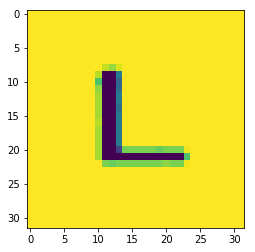

In [346]:
test_model_on_image(loaded_model,'../../index.png')  ##random image downloaded from internet

Class :  [41]
ற்


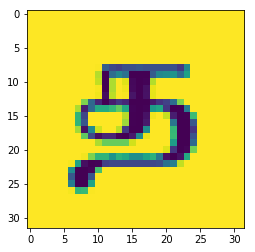

In [347]:
test_model_on_image(loaded_model,'../../index2.png')  ##random image downloaded from internet

Class :  [44]
ல்


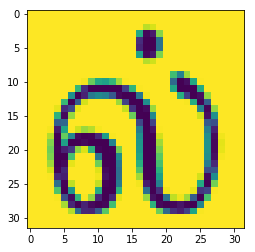

In [348]:
test_model_on_image(loaded_model,'../../index3.png') ##random image downloaded from internet

In [349]:
def plot_model():
    history = load(open("trainHistoryfilters3.pkl", "rb"))
    print(history['acc'])
    print(history.keys())
    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('model_accuracy_filters3.png')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('model_loss_filters3.png')
    plt.show()

[0.86715949820788529, 0.95957661290322582, 0.97105734767025087, 0.97456317204301079, 0.97844982078853049]
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


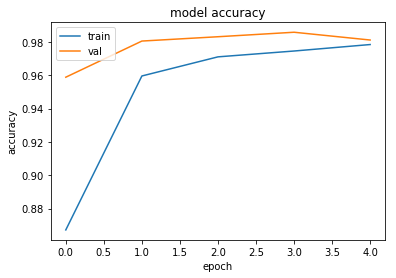

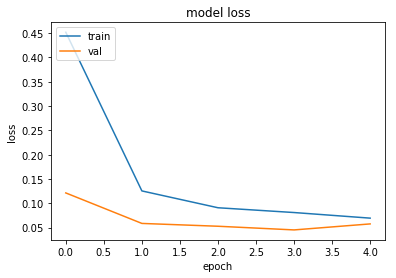

In [350]:
plot_model()